# 02 – Model Experiments for Pima Indians Diabetes

In [2]:
from pathlib import Path
import sys

def detect_project_root() -> Path:
    """
    Suy ra PROJECT_ROOT một cách linh hoạt cho notebook.
    - Nếu đang đứng ở pima-diabetes-project (có thư mục src/) -> dùng cwd.
    - Nếu đang đứng ở notebooks/ -> dùng parent của cwd.
    - Nếu không, fallback dùng cwd.
    """
    cwd = Path.cwd().resolve()
    if (cwd / "src").exists():
        return cwd
    if (cwd.parent / "src").exists():
        return cwd.parent
    return cwd

PROJECT_ROOT = detect_project_root()
print("PROJECT_ROOT:", PROJECT_ROOT)

# Thêm project_root vào sys.path nếu chưa có
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


PROJECT_ROOT: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project


In [3]:
from src.utils.config import FIGURES_DIR

# Tạo thư mục figures nếu chưa có
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
print("FIGURES_DIR:", FIGURES_DIR)


FIGURES_DIR: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures


Cell 2 – Import thư viện & thiết lập chung

In [4]:
from __future__ import annotations

import logging
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from src.preprocessing.data_preprocessor import (
    DataPreprocessor,
    PreprocessorConfig,
    DataPreprocessorError,
)
from src.modeling.model_trainer import (
    ModelTrainer,
    TrainerConfig,
    ModelTrainerError,
)

# Thiết lập style cho plot
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Logging
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s - %(name)s - %(message)s",
)
logger = logging.getLogger("MODEL_EXPERIMENTS")

# Seed chung cho mọi thao tác random trong notebook
RANDOM_STATE: int = 42
np.random.seed(RANDOM_STATE)


Cell 3 – Hàm detect PROJECT_ROOT (không hard-code)

In [5]:
def detect_project_root() -> Path:
    """
    Cố gắng suy ra PROJECT_ROOT một cách linh hoạt:
    - Nếu đang đứng ở project_root (có thư mục src/ và data/) → dùng cwd.
    - Nếu đang đứng ở notebooks/ → project_root = parent của cwd.
    """
    cwd = Path.cwd().resolve()
    if (cwd / "src").exists() and (cwd / "data").exists():
        return cwd
    if (cwd.parent / "src").exists() and (cwd.parent / "data").exists():
        return cwd.parent
    return cwd  # fallback (trường hợp IDE đặc biệt)


PROJECT_ROOT: Path = detect_project_root()
DATA_RAW_DIR: Path = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR: Path = PROJECT_ROOT / "data" / "processed"
MODELS_DIR: Path = PROJECT_ROOT / "models"

logger.info("PROJECT_ROOT: %s", PROJECT_ROOT)
logger.info("DATA_RAW_DIR: %s", DATA_RAW_DIR)
logger.info("DATA_PROCESSED_DIR: %s", DATA_PROCESSED_DIR)
logger.info("MODELS_DIR: %s", MODELS_DIR)


[2025-12-11 15:05:15,144] INFO - MODEL_EXPERIMENTS - PROJECT_ROOT: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project
[2025-12-11 15:05:15,145] INFO - MODEL_EXPERIMENTS - DATA_RAW_DIR: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\data\raw
[2025-12-11 15:05:15,146] INFO - MODEL_EXPERIMENTS - DATA_PROCESSED_DIR: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\data\processed
[2025-12-11 15:05:15,146] INFO - MODEL_EXPERIMENTS - MODELS_DIR: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\models


Cell 4a – Load dữ liệu đã được xử lý bởi main.py (Processed Data)

In [6]:
try:
    # Đường dẫn file đã processed (được main.py lưu)
    train_path = DATA_PROCESSED_DIR / "pima_train_processed.parquet"
    test_path = DATA_PROCESSED_DIR / "pima_test_processed.parquet"

    if not train_path.exists() or not test_path.exists():
        raise FileNotFoundError("Không tìm thấy file dữ liệu processed. Hãy chạy main.py trước!")

    # Load dữ liệu
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)

    # Tách X và y (Giả sử cột target tên là "Outcome" như trong config)
    target_col = "Outcome"

    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    logger.info("Đã load dữ liệu Processed từ đĩa.")
    logger.info("X_train: %s, X_test: %s", X_train.shape, X_test.shape)

    # Hiển thị thử
    display(X_train.head(3))

except Exception as e:
    logger.error("Lỗi khi load dữ liệu: %s", e)
    raise

[2025-12-11 15:05:15,168] INFO - MODEL_EXPERIMENTS - Đã load dữ liệu Processed từ đĩa.
[2025-12-11 15:05:15,169] INFO - MODEL_EXPERIMENTS - X_train: (614, 19), X_test: (154, 19)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancy_high,Glucose_x_BMI,Insulin_div_Glucose,BMI_category_Underweight,BMI_category_Normal,BMI_category_Overweight,BMI_category_Obese,Age_group_21-30,Age_group_31-40,Age_group_41-50,Age_group_>50
0,-0.855120,-1.057086,-0.859727,-1.980307,-1.530056,-0.781428,0.393103,-0.798419,-1.088602,-1.089033,-1.823602,False,False,True,False,True,False,False,False
1,0.360963,0.142577,0.496835,-0.243826,-1.896731,-0.418299,-0.093401,0.572372,0.918610,-0.179309,-1.823602,False,False,True,False,False,True,False,False
2,-0.551100,-0.557227,-1.198867,1.368619,-0.639561,0.383609,-0.831784,-0.712745,-1.088602,-0.225519,-0.465740,False,False,False,True,True,False,False,False


Cell 4b - Vẽ Heatmap tương quan (Correlation Matrix)


[2025-12-11 15:05:16,506] INFO - MODEL_EXPERIMENTS - Đã lưu Heatmap tương quan vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\correlation_heatmap.png


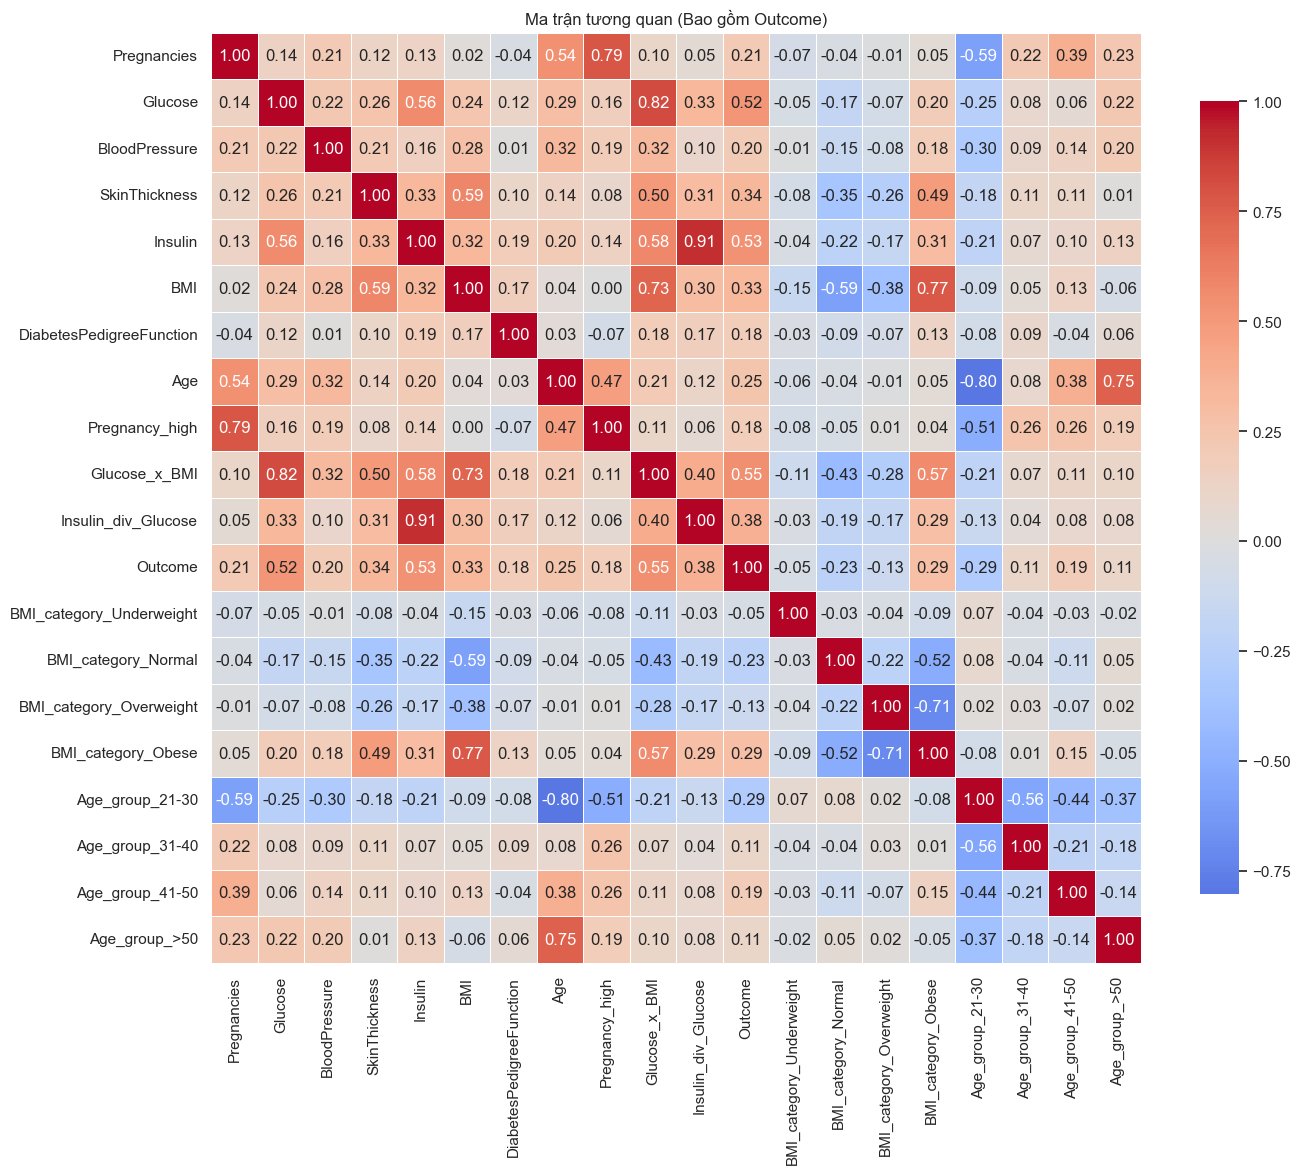

In [7]:
# -----------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# SỬA LẠI: Dùng train_df thay vì X_train để có cả cột Outcome
# train_df này đã được load ở Cell 5 và chứa toàn bộ dữ liệu đã xử lý (encoded + scaled)
corr_matrix = train_df.corr()

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(14, 12))  # Tăng size để số liệu không bị chồng chéo
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True,        # BẬT hiển thị số để xem cụ thể tương quan
    fmt=".2f"          # Lấy 2 chữ số thập phân
)

ax.set_title("Ma trận tương quan (Bao gồm Outcome)")
plt.tight_layout()

# Lưu ảnh
save_path = FIGURES_DIR / "correlation_heatmap.png"
fig.savefig(save_path, dpi=300)
logger.info("Đã lưu Heatmap tương quan vào: %s", save_path)

plt.show()

Cell 4c - Bảng xếp hạng độ tương quan với Outcome


===== BẢNG XẾP HẠNG TƯƠNG QUAN VỚI OUTCOME =====
Glucose_x_BMI               0.553055
Insulin                     0.533979
Glucose                     0.516144
Insulin_div_Glucose         0.376452
SkinThickness               0.340136
BMI                         0.334098
BMI_category_Obese          0.285827
Age                         0.245592
Pregnancies                 0.206870
BloodPressure               0.198224
Age_group_41-50             0.193982
Pregnancy_high              0.177949
DiabetesPedigreeFunction    0.177755
Age_group_31-40             0.106174
Age_group_>50               0.105766
BMI_category_Underweight   -0.051253
BMI_category_Overweight    -0.133686
BMI_category_Normal        -0.226256
Age_group_21-30            -0.289967
Name: Outcome, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_17620\143365188.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_corr.values, y=sorted_corr.index, ax=ax, palette="viridis")
[2025-12-11 15:05:17,414] INFO - MODEL_EXPERIMENTS - Đã lưu biểu đồ xếp hạng tương quan vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\correlation_ranking.png


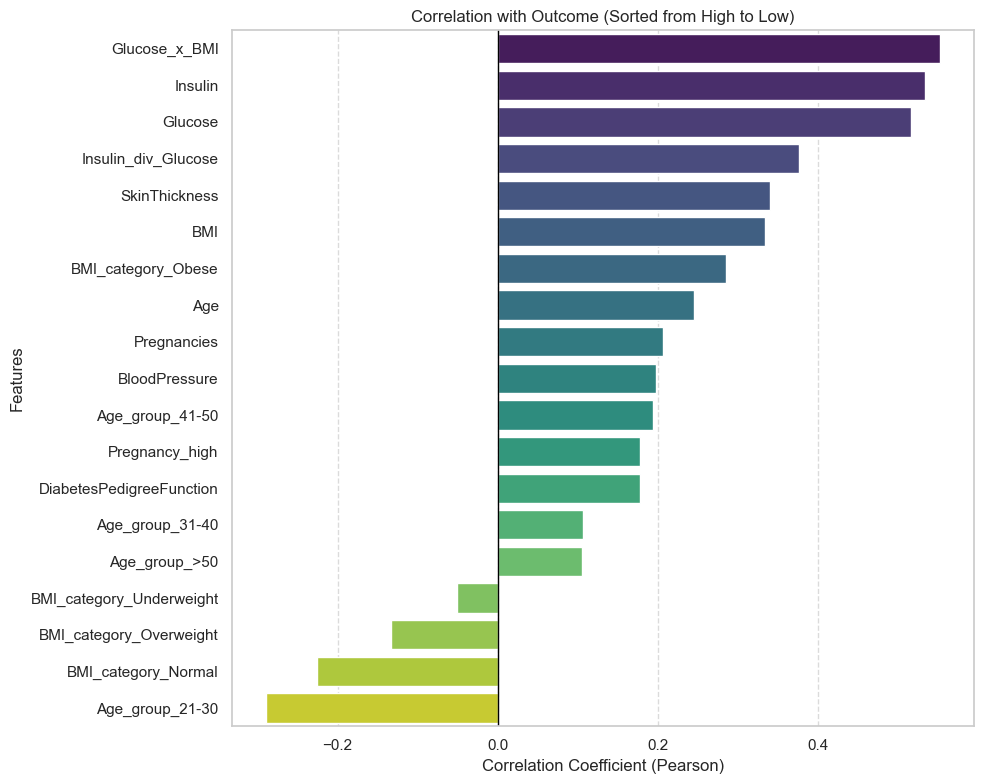

In [8]:
# -----------------------------------------------------------
# 1. Tính tương quan của tất cả các biến với Outcome và bỏ dòng Outcome đi
corr_with_target = train_df.corr()["Outcome"].drop("Outcome")

# 2. Sắp xếp từ cao xuống thấp
# Giá trị dương cao: Tỷ lệ thuận (Feature tăng -> Nguy cơ bệnh tăng)
# Giá trị âm cao: Tỷ lệ nghịch (Feature tăng -> Nguy cơ bệnh giảm)
sorted_corr = corr_with_target.sort_values(ascending=False)

# 3. In bảng số liệu ra màn hình để xem chi tiết
print("===== BẢNG XẾP HẠNG TƯƠNG QUAN VỚI OUTCOME =====")
print(sorted_corr)

# 4. Vẽ biểu đồ cột (Bar Chart) trực quan
fig, ax = plt.subplots(figsize=(10, 8))

# Dùng palette màu: Xanh lá (tương quan dương) -> Tím (tương quan âm)
sns.barplot(x=sorted_corr.values, y=sorted_corr.index, ax=ax, palette="viridis")

# Trang trí biểu đồ
ax.set_title("Correlation with Outcome (Sorted from High to Low)")
ax.set_xlabel("Correlation Coefficient (Pearson)")
ax.set_ylabel("Features")
ax.axvline(x=0, color='black', linestyle='-', linewidth=1) # Đường kẻ mốc 0
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

# Lưu ảnh
save_path = FIGURES_DIR / "correlation_ranking.png"
fig.savefig(save_path, dpi=300)
logger.info("Đã lưu biểu đồ xếp hạng tương quan vào: %s", save_path)

plt.show()

Cell 4d - Kiểm tra tỷ lệ Outlier trên dữ liệu gốc (Raw Data)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from typing import Dict, Tuple


def train_baseline_logistic(
    X_tr: pd.DataFrame,
    y_tr: pd.Series,
    X_te: pd.DataFrame,
    y_te: pd.Series,
) -> Tuple[LogisticRegression, Dict[str, float]]:
    """
    Huấn luyện Logistic Regression baseline:
    - Không GridSearch, chỉ dùng hyper-parameters mặc định hợp lý.
    - Fit trên Train, đánh giá trên Test.
    - Trả về (model, metrics).
    """
    model = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    metrics: Dict[str, float] = {}
    metrics["accuracy"] = accuracy_score(y_te, y_pred)
    metrics["precision"] = precision_score(y_te, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_te, y_pred, zero_division=0)
    metrics["f1"] = f1_score(y_te, y_pred, zero_division=0)
    metrics["roc_auc"] = roc_auc_score(y_te, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    metrics["tn"], metrics["fp"], metrics["fn"], metrics["tp"] = map(float, (tn, fp, fn, tp))

    logger.info("Baseline Logistic Regression – classification report:\n%s",
                classification_report(y_te, y_pred, zero_division=0))

    return model, metrics


baseline_model, baseline_metrics = train_baseline_logistic(X_train, y_train, X_test, y_test)
baseline_metrics


[2025-12-11 15:05:17,572] INFO - MODEL_EXPERIMENTS - Baseline Logistic Regression – classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       100
           1       0.68      0.91      0.78        54

    accuracy                           0.82       154
   macro avg       0.81      0.84      0.81       154
weighted avg       0.85      0.82      0.82       154



{'accuracy': 0.8181818181818182,
 'precision': 0.6805555555555556,
 'recall': 0.9074074074074074,
 'f1': 0.7777777777777778,
 'roc_auc': np.float64(0.8546296296296296),
 'tn': 77.0,
 'fp': 23.0,
 'fn': 5.0,
 'tp': 49.0}

Cell 5b - Train Baseline Random Forest (Mặc định, không chỉnh tham số)

In [10]:
from sklearn.ensemble import RandomForestClassifier

def train_baseline_rf(X_tr, y_tr, X_te, y_te):
    """
    Huấn luyện Random Forest mặc định hoàn toàn.
    Chỉ set random_state để kết quả không nhảy lung tung.
    """
    logger.info("Đang train Baseline Random Forest...")
    
    # KHÔNG set class_weight, max_depth, n_estimators (dùng mặc định 100)...
    model = RandomForestClassifier(random_state=42)
    model.fit(X_tr, y_tr)

    # Đánh giá
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    metrics = {}
    metrics["accuracy"] = accuracy_score(y_te, y_pred)
    metrics["precision"] = precision_score(y_te, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_te, y_pred, zero_division=0)
    metrics["f1"] = f1_score(y_te, y_pred, zero_division=0)
    metrics["roc_auc"] = roc_auc_score(y_te, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    metrics["tn"], metrics["fp"], metrics["fn"], metrics["tp"] = map(float, (tn, fp, fn, tp))

    logger.info("Baseline RF Metrics: %s", metrics)
    return model, metrics

# Gọi hàm
baseline_rf_model, baseline_rf_metrics = train_baseline_rf(X_train, y_train, X_test, y_test)

[2025-12-11 15:05:17,585] INFO - MODEL_EXPERIMENTS - Đang train Baseline Random Forest...
[2025-12-11 15:05:17,751] INFO - MODEL_EXPERIMENTS - Baseline RF Metrics: {'accuracy': 0.8831168831168831, 'precision': 0.8461538461538461, 'recall': 0.8148148148148148, 'f1': 0.8301886792452831, 'roc_auc': np.float64(0.9527777777777778), 'tn': 92.0, 'fp': 8.0, 'fn': 10.0, 'tp': 44.0}


Cell 6 – Load Model đã train từ thư mục models/

In [11]:
try:
    # 1. Khởi tạo Trainer (chỉ cần chỉ định thư mục chứa model)
    # Chúng ta dùng config mặc định, chỉ cần override đường dẫn output
    trainer_config = TrainerConfig(model_output_dir=MODELS_DIR)
    trainer = ModelTrainer(config=trainer_config)

    # 2. Load các model bạn muốn phân tích
    # Tên file thường là {model_name}_best.joblib do main.py lưu
    trainer.load_saved_model("log_reg")
    trainer.load_saved_model("random_forest")

    # 3. Tính toán lại metrics trên tập Test (vì load lên thì chưa có metrics sẵn trong RAM)
    logger.info("Đang tính toán lại metrics trên tập Test...")
    for name, model in trainer.best_models_.items():
        metrics = trainer.evaluate_on_test(model, X_test, y_test)
        trainer.test_metrics_[name] = metrics

    # 4. Xác định lại Best Model (để dùng cho các bước vẽ biểu đồ sau)
    # Tự động chọn dựa trên F1 (hoặc bạn có thể gán cứng tên model: best_name = "random_forest")
    best_score = -1
    best_name = None
    for name, m in trainer.test_metrics_.items():
        if m["f1"] > best_score:
            best_score = m["f1"]
            best_name = name

    trainer.best_model_name_ = best_name

    logger.info("Load hoàn tất.")
    logger.info("Các model hiện có: %s", list(trainer.best_models_.keys()))
    logger.info("Model tốt nhất hiện tại: %s (F1=%.4f)", best_name, best_score)

except Exception as e:
    logger.error("Lỗi khi load model: %s", e)
    # Gợi ý: Nếu lỗi file not found, nhắc user chạy main.py
    print("GỢI Ý: Bạn đã chạy 'python main.py' để tạo file model chưa?")
    raise

[2025-12-11 15:05:17,764] INFO - src.modeling.model_trainer - Khởi tạo ModelTrainer với config: ModelTrainer(models=['log_reg', 'random_forest'], scoring_primary=f1, cv_splits=5, use_smote=True)
[2025-12-11 15:05:17,767] INFO - src.modeling.model_trainer - Đã load model 'log_reg' từ: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\models\log_reg_best.joblib
[2025-12-11 15:05:17,823] INFO - src.modeling.model_trainer - Đã load model 'random_forest' từ: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\models\random_forest_best.joblib
[2025-12-11 15:05:17,824] INFO - MODEL_EXPERIMENTS - Đang tính toán lại metrics trên tập Test...
[2025-12-11 15:05:17,838] INFO - src.modeling.model_trainer - Classification report trên test:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       100
           1       0.68      0.89      0.77        54

    accuracy                           0.81       154
   macro avg       0.80

Cell 7 – So sánh Baseline vs các model (bảng + barplot)

,model,type,f1,roc_auc,accuracy,precision,recall
0,Baseline LogReg (Default),Baseline,0.777778,0.854630,0.818182,0.680556,0.907407
1,Baseline RF (Default),Baseline,0.830189,0.952778,0.883117,0.846154,0.814815
2,Tuned Log Reg,Tuned,0.768000,0.852407,0.811688,0.676056,0.888889
3,Tuned Random Forest,Tuned,0.842105,0.955370,0.883117,0.800000,0.888889


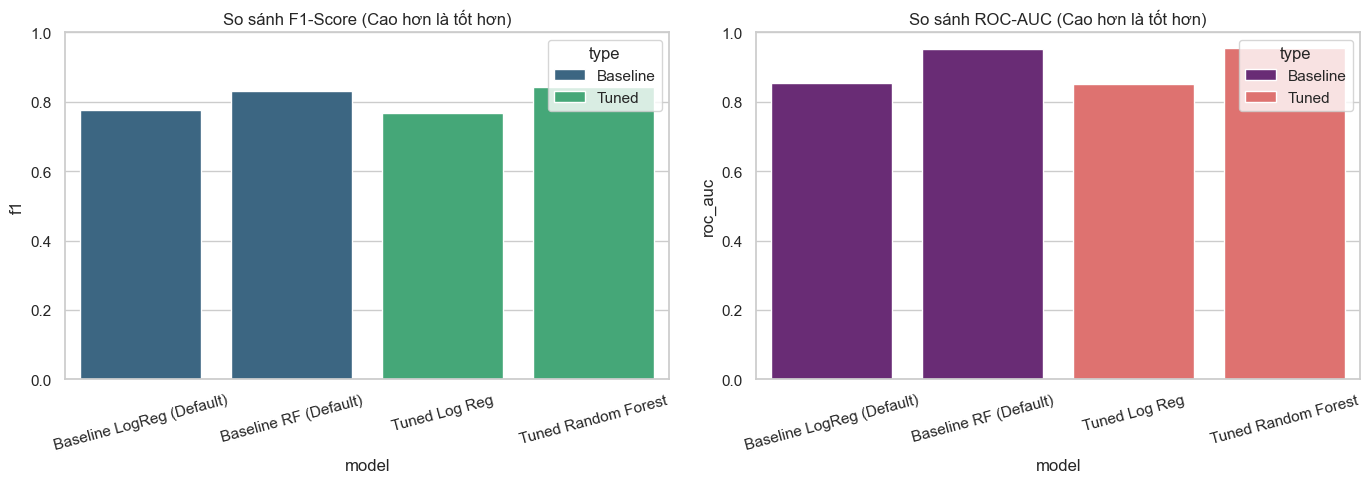

In [12]:
rows = []

# 1. Baseline Logistic Regression (từ Cell 6)
if 'baseline_metrics' in locals():
    row_base_lr = {"model": "Baseline LogReg (Default)", "type": "Baseline"}
    row_base_lr.update(baseline_metrics)
    rows.append(row_base_lr)

# 2. Baseline Random Forest (từ Cell 6b mới)
if 'baseline_rf_metrics' in locals():
    row_base_rf = {"model": "Baseline RF (Default)", "type": "Baseline"}
    row_base_rf.update(baseline_rf_metrics)
    rows.append(row_base_rf)

# 3. Tuned Models (từ Cell 7 - đã load từ file hoặc train mới)
# trainer.test_metrics_ chứa kết quả của model đã được GridSearch/RandomSearch
for name, m in trainer.test_metrics_.items():
    # Đổi tên cho đẹp
    display_name = f"Tuned {name.replace('_', ' ').title()}"
    row_tuned = {"model": display_name, "type": "Tuned"}
    row_tuned.update(m)
    rows.append(row_tuned)

# Tạo DataFrame
metrics_df = pd.DataFrame(rows)

# Sắp xếp lại cột cho dễ nhìn
cols_order = ["model", "type", "f1", "roc_auc", "accuracy", "precision", "recall"]
# Chỉ lấy các cột tồn tại
cols_order = [c for c in cols_order if c in metrics_df.columns]
display(metrics_df[cols_order])

# --- Vẽ biểu đồ so sánh ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ F1-Score
sns.barplot(data=metrics_df, x="model", y="f1", hue="type", ax=axes[0], palette="viridis")
axes[0].set_title("So sánh F1-Score (Cao hơn là tốt hơn)")
axes[0].tick_params(axis='x', rotation=15)
axes[0].set_ylim(0, 1.0)

# Biểu đồ ROC-AUC
sns.barplot(data=metrics_df, x="model", y="roc_auc", hue="type", ax=axes[1], palette="magma")
axes[1].set_title("So sánh ROC-AUC (Cao hơn là tốt hơn)")
axes[1].tick_params(axis='x', rotation=15)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

Cell 8 – Vẽ Confusion Matrix của model tốt nhất

[2025-12-11 15:05:18,351] INFO - MODEL_EXPERIMENTS - Đã lưu confusion matrix vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\confusion_matrix_best.png


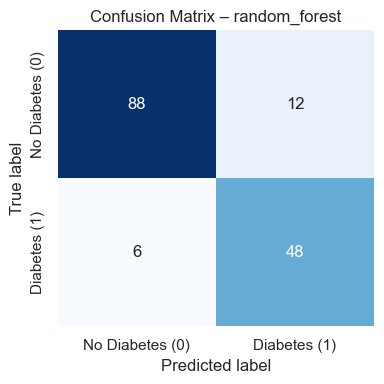

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str = "Confusion Matrix",
    save_path: Path | None = None,
) -> None:
    """
    Vẽ confusion matrix dạng heatmap và (nếu có) lưu ra file.
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)
    ax.set_xticklabels(["No Diabetes (0)", "Diabetes (1)"])
    ax.set_yticklabels(["No Diabetes (0)", "Diabetes (1)"])
    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        logger.info("Đã lưu confusion matrix vào: %s", save_path)

    plt.show()
    plt.close(fig)


best_name = trainer.best_model_name_
best_model = trainer.best_models_[best_name]

y_pred_best = best_model.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_best,
    title=f"Confusion Matrix – {best_name}",
    save_path=FIGURES_DIR / "confusion_matrix_best.png",
)


Cell 9 – Vẽ ROC Curve của model tốt nhất

[2025-12-11 15:05:18,814] INFO - MODEL_EXPERIMENTS - Đã lưu biểu đồ so sánh ROC vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\roc_curve_comparison_4_models.png


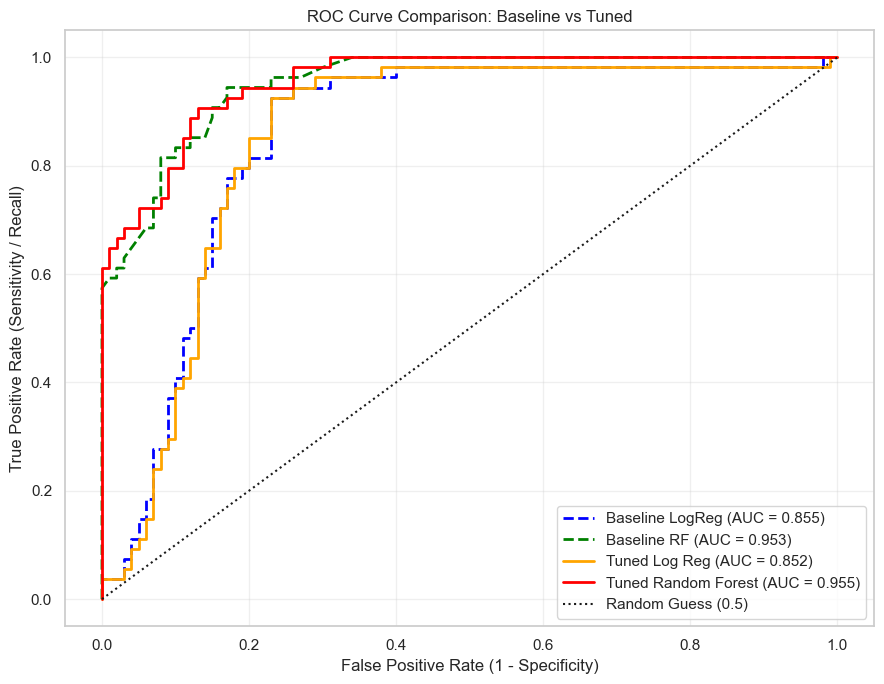

In [14]:
# -----------------------------------------------------------
from sklearn.metrics import roc_curve, auc

# 1. Gom tất cả model vào dictionary
all_models = {}

# Baseline LogReg
if 'baseline_model' in locals():
    all_models["Baseline LogReg"] = baseline_model

# Baseline RF
if 'baseline_rf_model' in locals():
    all_models["Baseline RF"] = baseline_rf_model

# Tuned Models (Load từ Trainer)
for name, model in trainer.best_models_.items():
    display_name = f"Tuned {name.replace('_', ' ').title()}"
    all_models[display_name] = model

# 2. Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(9, 7))

colors = ['blue', 'green', 'orange', 'red'] # Màu cho 4 đường
line_styles = ['--', '--', '-', '-']        # Baseline nét đứt, Tuned nét liền

for (label, mdl), color, style in zip(all_models.items(), colors, line_styles):
    # Lấy xác suất lớp 1
    if hasattr(mdl, "predict_proba"):
        y_score = mdl.predict_proba(X_test)[:, 1]
    elif hasattr(mdl, "decision_function"):
        y_score = mdl.decision_function(X_test)
    else:
        print(f"Model {label} không hỗ trợ xuất xác suất.")
        continue

    # Tính FPR, TPR
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc_val = auc(fpr, tpr)

    # Vẽ đường
    ax.plot(
        fpr, tpr,
        label=f"{label} (AUC = {roc_auc_val:.3f})",
        color=color,
        linestyle=style,
        linewidth=2
    )

# Đường chéo ngẫu nhiên
ax.plot([0, 1], [0, 1], "k:", label="Random Guess (0.5)")

ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity / Recall)")
ax.set_title("ROC Curve Comparison: Baseline vs Tuned")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = FIGURES_DIR / "roc_curve_comparison_4_models.png"
fig.savefig(save_path, dpi=300)
logger.info("Đã lưu biểu đồ so sánh ROC vào: %s", save_path)

plt.show()

Cell 10 – Feature Importance & SHAP cho model tốt nhất

[2025-12-11 15:05:19,253] INFO - MODEL_EXPERIMENTS - Đã lưu feature importance RF vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\feature_importance_rf.png


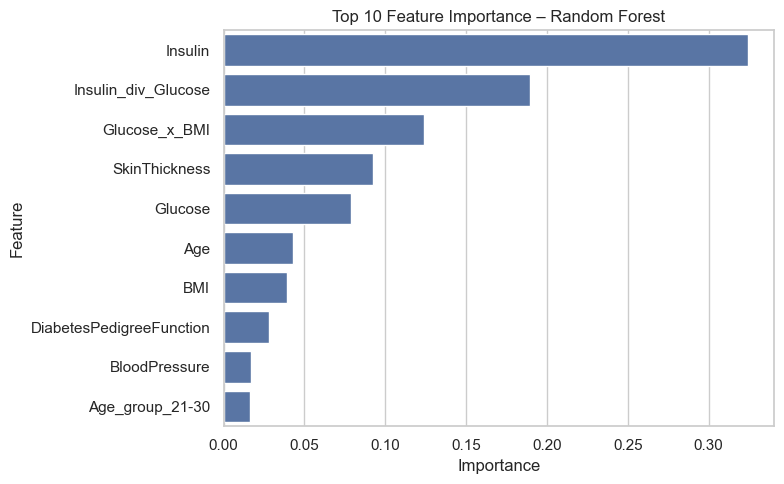

In [15]:
# Lấy feature importance của Random Forest (từ Trainer)
rf_imp_df = trainer.get_feature_importance(
    model_name="random_forest",
    feature_names=X_train.columns.tolist(),
)

top_k = 10
rf_top = rf_imp_df.head(top_k)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=rf_top,
    x="importance",
    y="feature",
    ax=ax,
)
ax.set_title(f"Top {top_k} Feature Importance – Random Forest")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.tight_layout()

out_path = FIGURES_DIR / "feature_importance_rf.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
logger.info("Đã lưu feature importance RF vào: %s", out_path)

plt.show()
plt.close(fig)


Cell 11 – Kết luận thí nghiệm (Markdown)

[2025-12-11 15:05:23,093] INFO - MODEL_EXPERIMENTS - ===== TOP 10 SHAP MEAN(|VALUE|) (random_forest) =====
[2025-12-11 15:05:23,095] INFO - MODEL_EXPERIMENTS - 
    feature  mean_abs_shap
    Glucose       0.017196
Pregnancies       0.017196
C:\Users\HP\AppData\Local\Temp\ipykernel_17620\650814526.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
[2025-12-11 15:05:23,840] INFO - MODEL_EXPERIMENTS - Đã lưu SHAP summary plot vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\shap_summary.png


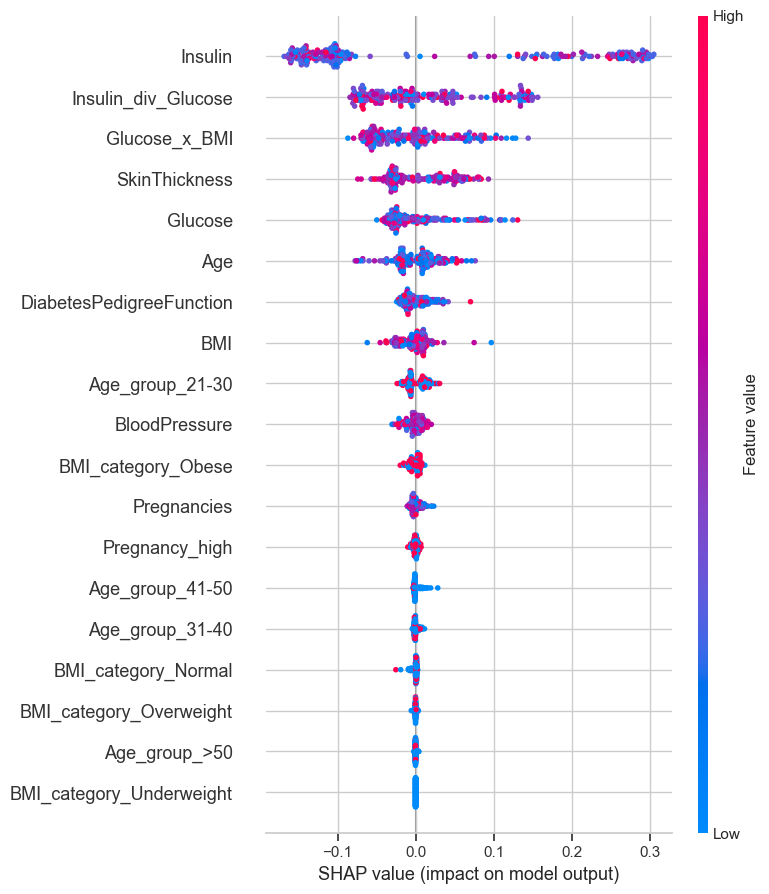

[2025-12-11 15:05:24,947] INFO - MODEL_EXPERIMENTS - Đã lưu SHAP waterfall cho bệnh nhân 0 vào: E:\3_CODING\Python\Python cho kdl\PRO\PT\pima-diabetes-project\reports\figures\shap_waterfall_patient_0.png


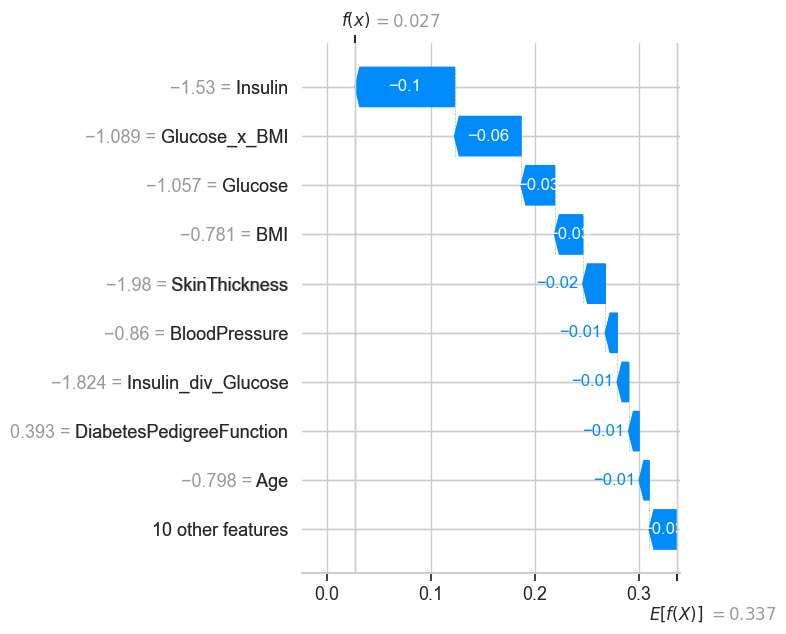

In [16]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === 1. Tính SHAP values bằng ModelTrainer ===
shap_values, shap_imp_df = trainer.compute_shap_values(
    model_name=best_name,
    X_sample=X_train,
    max_samples=200,
)

logger.info("===== TOP 10 SHAP MEAN(|VALUE|) (%s) =====", best_name)
logger.info("\n%s", shap_imp_df.head(10).to_string(index=False))

# === 2. Xử lý đa lớp (nếu có) ===
values_arr = np.asarray(shap_values.values)

if values_arr.ndim == 3 and values_arr.shape[2] >= 2:
    # (n_samples, n_features, n_classes) -> lấy lớp positive (class 1)
    shap_values_pos = shap_values[:, :, 1]  # vẫn là Explanation
else:
    # Trường hợp nhị phân thường: (n_samples, n_features)
    shap_values_pos = shap_values          # Explanation

# Số sample mà SHAP thực sự tính
values_pos_arr = np.asarray(shap_values_pos.values)
n_shap = values_pos_arr.shape[0]

# Dùng đúng số dòng tương ứng trong X_train
X_for_shap = X_train.iloc[:n_shap, :]

# =======================================================
# 1) SHAP SUMMARY PLOT — tên feature + show + save
# =======================================================

plt.figure()
shap.summary_plot(
    shap_values_pos,
    features=X_for_shap,                 # DataFrame -> có tên feature
    feature_names=X_for_shap.columns,    # đảm bảo nhãn đúng
    show=False                          # để tự control show/save
)

plt.tight_layout()
summary_path = FIGURES_DIR / "shap_summary.png"
plt.savefig(summary_path, dpi=300, bbox_inches="tight")
logger.info("Đã lưu SHAP summary plot vào: %s", summary_path)

plt.show()   # hiện hình ra console
plt.close()

# =======================================================
# 2) WATERFALL CHO 1 BỆNH NHÂN — tên feature + show + save
# =======================================================

idx = 0  # bệnh nhân đầu tiên trong X_for_shap

# Tạo Explanation đầy đủ cho 1 bệnh nhân (để có feature_names đúng)
exp = shap.Explanation(
    values=values_pos_arr[idx],                          # vector SHAP (n_features,)
    base_values=np.asarray(shap_values_pos.base_values)[idx],
    data=X_for_shap.iloc[idx],
    feature_names=X_for_shap.columns
)

plt.figure()
shap.plots.waterfall(exp, show=False)

plt.tight_layout()
waterfall_path = FIGURES_DIR / "shap_waterfall_patient_0.png"
plt.savefig(waterfall_path, dpi=300, bbox_inches="tight")
logger.info(
    "Đã lưu SHAP waterfall cho bệnh nhân %d vào: %s", idx, waterfall_path
)

plt.show()   # hiện hình ra console
plt.close()
